In [69]:
!pip install scikit-posthocs

In [2]:
#Importing Libraries
import os
import pandas as pd
import numpy as np
import utility as util
import math
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import scikit_posthocs as sp
from scipy.stats import ttest_ind_from_stats
from scipy.stats import mannwhitneyu
from scipy.optimize import curve_fit
import seaborn as sns
import plotly
import plotly.graph_objects as go    # for data visualisation
import plotly.figure_factory as ff
import plotly.express as px
from pycountry_convert import country_name_to_country_alpha3 # for choropleth maps

In [3]:
df=pd.read_csv('../vuln_data/countries.csv')

#df.iloc[:,np.r_[:,23:324]].columns.tolist()

colnames=df.columns.tolist()
cverange = [colnames.index(l) for l in colnames if l.startswith('CVE-')]


In [4]:
#from https://www.imd.org/wcc/world-competitiveness-center-rankings/world-digital-competitiveness-rankings-2020/
top_gdp=['United Kingdom','Austria','Hong Kong','United Arab Emirates','Norway','Singapore','Denmark','Sweden','Switzerland','Netherlands','South Korea','Finland','Taiwan','Taiwan','Canada','Australia','Germany','Estonia','Israel','Ireland','New Zealand','Iceland','France','Belgium','Japan','Saudi Arabia','Luxembourg','Qatar','Slovenia','Spain','Saudi Arabia','Czech Republic','Portugal','Cyprus','Italy']
bottom_gdp=['China','Malyasia','Lithuania','Poland','Kazakhstan','Latvia','Thailand','Chile','Russia','Turkey','Bulgaria','Greece','Hungary','India','Romania','Slovak Republic','Brazil','Croatia','Jordan','Mexico','Peru','Indonesia','Philippines','Ukraine','Argentina','South Africa','Colombia','Mongolia']

Enrich dataframe with cvss info

In [5]:
df_cvss=pd.read_csv('../vuln_data/exposure-count.csv')

def getbscorebyname(cve):  #return CVSSv3 base score by CVE ID
    return(df_cvss['cvss3_basescore'][df_cvss.vulnerability.str.contains(cve.strip())].values[0])

def getbscorebyname2(cve):  #return CVSSv2 base score by CVE ID
    return(df_cvss['cvss2_basescore'][df_cvss.vulnerability.str.contains(cve.strip())].values[0])


def ttestcountries(c1, c2):  #perform a t-test on two countries
    mean1, std1, nobs1 = country_bscore[country_bscore.country==c1][['avg','std','ncve']].values[0]
    mean2, std2, nobs2 = country_bscore[country_bscore.country==c2][['avg','std','ncve']].values[0]
    return(ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2, equal_var=False))


In [6]:
#create a dataframe with the CVSS score averages and standard deviation info
country_bscore=df.copy()

country_bscore['vulnper1k']=country_bscore['totalcount']/(country_bscore['population_2020']/1000)

cvelist=df.iloc[:,np.r_[:,min(cverange):max(cverange)+1]].columns.tolist() #this needs to become neat, parse all columns starting with "CVE-"

country_bscore['ncve']=country_bscore['avg']=0
country_bscore['ncve2']=country_bscore['avg2']=0  #cvss2


for i in cvelist:
    country_bscore['ncve']+=country_bscore[i]
    country_bscore['avg']+=country_bscore[i]*getbscorebyname(i)
    country_bscore['ncve2']+=country_bscore[i]                        #cvss2
    country_bscore['avg2']+=country_bscore[i]*getbscorebyname2(i)    #cvss2

country_bscore['exposure']=country_bscore['avg']
country_bscore['exposureperperson']=country_bscore['avg']/(country_bscore['population_2020'])
country_bscore['avg']/=country_bscore.ncve
country_bscore['avg2']/=country_bscore.ncve   #cvss2


country_bscore['std']=0    
country_bscore['std2']=0     #cvss2


for i in cvelist:
    country_bscore['std']+=country_bscore[i]*(country_bscore['avg']-getbscorebyname(i))**2
    country_bscore['std2']+=country_bscore[i]*(country_bscore['avg2']-getbscorebyname2(i))**2  #cvss2

country_bscore['std']/=country_bscore.ncve
country_bscore['std']=np.sqrt(country_bscore['std'])

country_bscore['std2']/=country_bscore.ncve                #cvss2
country_bscore['std2']=np.sqrt(country_bscore['std2'])     #cvss2


country_bscore[['country','totalcount','vulnper1k','ncve','avg','std','avg2','std2', 'exposure','exposureperperson']].describe()

,totalcount,vulnper1k,ncve,avg,std,avg2,std2,exposure,exposureperperson
count,2.470000e+02,2.410000e+02,2.470000e+02,247.000000,247.000000,247.000000,247.000000,2.470000e+02,241.000000
mean,8.443286e+05,2.741690e+04,8.444824e+05,7.522181,1.604216,5.565825,1.332070,6.322610e+06,211.572680
std,3.359074e+06,3.571325e+05,3.359581e+06,0.317437,0.131439,0.186953,0.130714,2.490640e+07,2794.319244
min,0.000000e+00,1.649823e-02,3.000000e+01,6.250636,0.466977,4.548996,0.440820,2.169000e+02,0.000127
25%,5.468000e+03,1.920504e+00,5.468000e+03,7.320675,1.585355,5.496677,1.267519,4.139985e+04,0.014752
50%,3.306100e+04,1.555102e+01,3.306100e+04,7.582448,1.632663,5.581419,1.362632,2.523687e+05,0.119867
75%,3.080950e+05,1.263333e+02,3.081225e+05,7.732167,1.670477,5.657164,1.415005,2.341560e+06,0.948995
max,3.466126e+07,5.515871e+06,3.466703e+07,9.174815,1.898584,6.848239,1.637865,2.543718e+08,43199.725125


In [33]:
exposureperperson_topgdp=country_bscore[country_bscore.country.isin(top_gdp)][['country','exposureperperson']].sort_values(by='exposureperperson', ascending=False)
exposureperperson_bottomgdp=country_bscore[country_bscore.country.isin(bottom_gdp)][['country','exposureperperson']].sort_values(by='exposureperperson', ascending=False)
exposureperperson_topgini=country_bscore[country_bscore.exposureperperson<10][country_bscore.country.isin(top20_gini.country)][['country','exposureperperson']].sort_values(by='exposureperperson', ascending=False)
exposureperperson_bottomgini=country_bscore[country_bscore.exposureperperson<10][country_bscore.country.isin(bottom20_gini.country)][['country','exposureperperson']].sort_values(by='exposureperperson', ascending=False)

print(np.exp(35.695))
#city_bscore.city_type.hist()

fig = go.Figure()
fig.add_histogram(x=exposureperperson_topgini.exposureperperson)
fig.add_histogram(x=exposureperperson_bottomgini.exposureperperson)

fig.update_layout(title='',
                  xaxis = dict(title='exposure per person'), # categoryorder='array' ,categoryarray=['LOW','MEDIUM','HIGH','CRITICAL']),
                  yaxis = dict(title='Count'))

#fig.update_traces(opacity=0.75)

NameError: name 'top20_gini' is not defined

In [9]:
print(exposureperperson_topgini.describe())
print(exposureperperson_bottomgini.describe())


NameError: name 'exposureperperson_topgini' is not defined

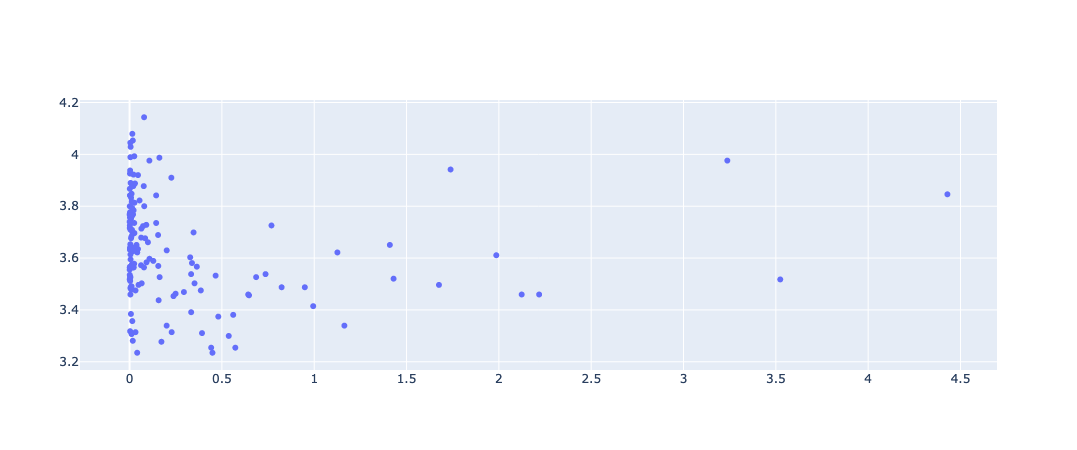

In [410]:
fig = go.Figure()


# Add traces
fig.add_trace(go.Scatter(x=country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>20)]['exposureperperson'], 
                         y=np.log(country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>20)]['gini_value']),
                    mode='markers',
                    name='markers'))

In [10]:
country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>0)]['exposureperperson'].corr(country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>0)]['gini_value'])

-0.08009056324000972

In [11]:
country_bscore[(country_bscore.exposureperperson<5) & 
               (country_bscore.factor_technology>0)]['exposureperperson'].corr(country_bscore[(country_bscore.exposureperperson<5) & 
                                                                                       (country_bscore.factor_technology>0)]['factor_technology'])

-0.319058111177202

In [12]:
gdp=pd.read_csv('../vuln_data/gdp.csv')
ccode=pd.read_csv('../vuln_data/country_iso.csv')
ccode.head(10)

def getincomebyccode(ccode2):
    try:
        ccode3=ccode[ccode['country_code']==ccode2]['ccode3'].values[0]
        return(gdp[gdp['Country Code']==ccode3]['IncomeGroup'].values[0][:-7])
    except :
        return(np.nan)
    

In [13]:
getincomebyccode('AL')

'Upper middle'

In [14]:
country_bscore['income_group']=country_bscore['country_code'].map(getincomebyccode)

country_bscore['gini_value']=np.where(country_bscore.gini_value>0, country_bscore.gini_value, np.nan)


In [15]:
x=country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>0)]['exposureperperson']
y=country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>0)]['gini_value']

#np.polyfit(np.log(x),y,1)  # y=A + B log x
#params, pcov =curve_fit(lambda t,a,b: a*np.exp(b*t), x, y, p0=[4,-0.1])
params, pcov =curve_fit(lambda t,a,b: a+b*np.log(t), x, y)
#fit1=params[0]*np.exp(params[1]*x)
fit2=params[0]+params[1]*np.log(x)
print(params,'\n',pcov,fit2)
country_bscore[[ 'country','income_group','population_2020',
        'overall_performance', 'factor_knowledge',
       'factor_technology', 'factor_future_readiness', 'subfact_know_talent',
       'subfact_know_training_education',
       'subfact_know_scientific_concentration',
       'subfact_tech_regulatory_framework', 'subfact_tech_capital',
       'subfact_tech_technological_framework', 'subfact_fr_adaptive_attitudes',
       'subfact_fr_business_agility', 'subfact_fr_it_integration',
       'gini_value', 'totalcount','avg','vulnper1k','exposureperperson']].to_csv('../vuln_data/exposure_g1.csv')

[35.73158129 -0.91793683] 
 [[1.18691661 0.24796213]
 [0.24796213 0.07781194]] 2      38.232775
3      41.041360
6      41.058516
9      38.133749
10     36.012541
         ...    
240    39.894389
241    39.212834
244    36.754058
245    40.789567
246    40.480285
Name: exposureperperson, Length: 148, dtype: float64


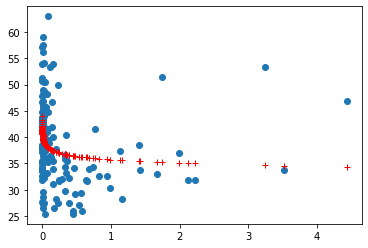

In [16]:
plt.plot(x, y, 'o', label="y-original")
plt.plot(x,fit2,'r+')

In [17]:
ttestcountries('Andorra','Yemen')

Ttest_indResult(statistic=3.3747513863256464, pvalue=0.0007399442863508931)

In [18]:
top_vuln_countries=country_bscore[['country','totalcount','ncve','avg','std']].sort_values(by='avg', ascending=False).head(30)

In [19]:
ttestcountries('Lebanon','Niue')

Ttest_indResult(statistic=5.864105182751156, pvalue=4.519355674642435e-09)

In [20]:
top_gdp_cve=country_bscore[['country','totalcount','ncve','avg','std']][country_bscore.country.isin(top_gdp)].sort_values(by='avg', ascending=False)

In [21]:
ttestcountries('Singapore','Switzerland')

Ttest_indResult(statistic=-128.5947808778528, pvalue=0.0)

In [22]:
top_gdp_cve.describe()

,totalcount,ncve,avg,std
count,3.300000e+01,3.300000e+01,33.000000,33.000000
mean,1.476177e+06,1.476219e+06,7.663650,1.654314
std,1.992775e+06,1.992856e+06,0.224594,0.052935
min,6.940000e+03,6.940000e+03,7.096534,1.525540
25%,1.407400e+05,1.407520e+05,7.586454,1.639208
50%,6.143100e+05,6.143100e+05,7.680451,1.658391
75%,2.439834e+06,2.439888e+06,7.797807,1.677193
max,8.102432e+06,8.103146e+06,8.046173,1.839198


In [23]:
top_vuln_countries.describe()

,totalcount,ncve,avg,std
count,3.000000e+01,3.000000e+01,30.000000,30.000000
mean,4.771415e+05,4.771638e+05,7.994191,1.583486
std,1.316038e+06,1.316137e+06,0.234829,0.126907
min,4.350000e+02,4.350000e+02,7.846275,1.243473
25%,1.781075e+04,1.781075e+04,7.904873,1.613820
50%,1.191955e+05,1.191955e+05,7.939898,1.634186
75%,2.834148e+05,2.834290e+05,8.004204,1.657188
max,6.774998e+06,6.775599e+06,9.174815,1.683552


In [26]:
mannwhitneyu(top_gdp_cve['avg'],top_vuln_countries['avg'])

MannwhitneyuResult(statistic=98.0, pvalue=2.4206238209381464e-08)

In [27]:

bottom_gdp_cve=country_bscore[['country','totalcount','ncve','avg','std']][country_bscore.country.isin(bottom_gdp)].sort_values(by='avg', ascending=False)

In [28]:
bottom_gdp_cve.describe()

,totalcount,ncve,avg,std
count,2.700000e+01,2.700000e+01,27.000000,27.000000
mean,2.578059e+06,2.578405e+06,7.688274,1.603278
std,6.673748e+06,6.674834e+06,0.234630,0.107972
min,1.388500e+04,1.388500e+04,7.176380,1.243473
25%,1.610520e+05,1.610610e+05,7.590544,1.593957
50%,4.153570e+05,4.153570e+05,7.649784,1.628174
75%,1.875798e+06,1.876071e+06,7.852742,1.667403
max,3.466126e+07,3.466703e+07,8.067863,1.736824


In [164]:
mannwhitneyu(bottom_gdp_cve['avg'],top_gdp_cve['avg'])

MannwhitneyuResult(statistic=425.0, pvalue=0.383165257951529)

In [165]:
mannwhitneyu(top_gdp_cve['avg'],top_vuln_countries['avg'])

MannwhitneyuResult(statistic=98.0, pvalue=2.4206238209381464e-08)

In [166]:
mannwhitneyu(bottom_gdp_cve['avg'],top_vuln_countries['avg'])

MannwhitneyuResult(statistic=132.5, pvalue=6.880915731583277e-06)

In [29]:
set(bottom_gdp) & set(top_vuln_countries.country)

{'Argentina',
 'Bulgaria',
 'Greece',
 'Latvia',
 'Lithuania',
 'Poland',
 'Slovak Republic'}

In [30]:
set(top_gdp) & set(top_vuln_countries.country)

{'Austria', 'Czech Republic', 'Denmark', 'New Zealand', 'Norway', 'Sweden'}

In [31]:
set(top_gdp) & set(bottom_gdp) #just checking

set()

In [32]:
top_vuln_countries

,country,totalcount,ncve,avg,std
116,Kuwait,21068,21068.0,9.174815,1.338345
240,Venezuela,37339,37339.0,8.169533,1.628903
119,Latvia,108938,108938.0,8.067863,1.664959
91,Guinea,1071,1071.0,8.061064,1.631290
58,Denmark,144578,144579.0,8.046173,1.666634
196,Slovak Republic,117363,117363.0,8.029063,1.653237
174,Republic of Moldova,222126,222127.0,8.027228,1.634347
125,Lithuania,382533,382539.0,8.008227,1.591884
242,Wallis and Futuna,2136,2136.0,7.992135,1.344734
21,Belize,161317,161320.0,7.986741,1.305961


In [379]:
#top20_gini=country_bscore[['country','totalcount','ncve','avg','std','gini_value']][country_bscore.country.isin(bottom_gdp)].sort_values(by='gini_value', ascending=False).head(30)
#bottom20_gini=country_bscore[['country','totalcount','ncve','avg','std','gini_value']][(country_bscore.country.isin(bottom_gdp)) & (country_bscore.gini_value>0)].sort_values(by='gini_value', ascending=True).head(30)

giniset=set(top_gdp)|set(bottom_gdp)


top20_gini=country_bscore.sort_values(by='gini_value',ascending=False).head(30)
bottom20_gini=country_bscore[country_bscore.gini_value>0].sort_values(by='gini_value').head(30)

#create top20 only with the top and bottomgdp
#top20_gini=country_bscore[country_bscore.country.isin(list(giniset))].sort_values(by='gini_value',ascending=False).head(20)
#bottom20_gini=country_bscore[(country_bscore.gini_value>0) & (country_bscore.country.isin(list(giniset)))].sort_values(by='gini_value').head(20)

set(top20_gini.country) & set(bottom20_gini.country)

set()

In [172]:
top20_gini[['gini_value','avg','ncve','std']].describe()

,gini_value,avg,ncve,std
count,20.000000,20.000000,2.000000e+01,20.000000
mean,53.015000,7.507082,3.143264e+05,1.611676
std,3.977076,0.292022,9.998297e+05,0.096996
min,48.300000,6.772178,5.870000e+02,1.305961
25%,50.275000,7.369017,6.578750e+03,1.600616
50%,52.400000,7.495237,2.698950e+04,1.619787
75%,54.700000,7.747629,1.440340e+05,1.656236
max,63.000000,7.986741,4.508313e+06,1.779735


In [173]:
bottom20_gini[['gini_value','avg','ncve','std']].describe()

,gini_value,avg,ncve,std
count,20.000000,20.000000,2.000000e+01,20.000000
mean,27.305000,7.662078,2.088394e+06,1.648783
std,1.346917,0.311996,7.692217e+06,0.069691
min,25.000000,6.999136,2.778000e+03,1.405668
25%,26.350000,7.558733,3.500875e+04,1.637993
50%,27.450000,7.691770,1.338040e+05,1.659012
75%,28.200000,7.911054,5.985180e+05,1.680580
max,29.500000,8.046173,3.466703e+07,1.736824


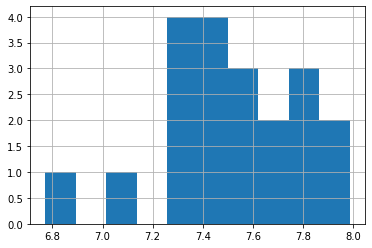

In [174]:
top20_gini['avg'].hist()

In [175]:
mannwhitneyu(top20_gini['avg'],bottom20_gini['avg'])

MannwhitneyuResult(statistic=138.0, pvalue=0.048098148124597825)

In [176]:
bottom20_gini.corr()

,population_2020,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,...,CVE-2020-0796,CVE-2020-11651,CVE-2020-11652,CVE-2020-1938,CVE-2020-5902,MS17-010,vulnper1k,ncve,avg,std
population_2020,1.000000,0.490710,0.222107,0.494049,0.469811,0.336202,-0.067392,0.343959,0.350281,0.442073,...,0.526102,0.480601,0.480601,0.525881,0.527344,0.528296,-0.098335,0.526697,-0.110215,-0.188440
overall_performance,0.490710,1.000000,0.929717,0.978926,0.990772,0.929007,0.483244,0.796569,0.927874,0.869671,...,0.586309,0.567355,0.567355,0.579798,0.577375,0.592048,0.071252,0.555932,-0.382480,-0.076299
factor_knowledge,0.222107,0.929717,1.000000,0.903235,0.902786,0.898678,0.634993,0.786453,0.908188,0.787347,...,0.298918,0.301086,0.301086,0.295576,0.293381,0.304422,0.095691,0.275151,-0.226382,0.036080
factor_technology,0.494049,0.978926,0.903235,1.000000,0.975185,0.920652,0.429644,0.792054,0.929561,0.897672,...,0.566012,0.544159,0.544159,0.564395,0.562807,0.574780,0.024367,0.540457,-0.346801,-0.023957
factor_future_readiness,0.469811,0.990772,0.902786,0.975185,1.000000,0.911603,0.476798,0.748300,0.942798,0.834719,...,0.593097,0.571118,0.571118,0.586736,0.584420,0.595885,0.057283,0.561648,-0.383484,-0.094628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MS17-010,0.528296,0.592048,0.304422,0.574780,0.595885,0.460532,-0.066021,0.450385,0.451502,0.551035,...,0.998643,0.981447,0.981447,0.998372,0.997909,1.000000,0.192803,0.995089,-0.386089,-0.104250
vulnper1k,-0.098335,0.071252,0.095691,0.024367,0.057283,0.179997,-0.138088,0.410954,-0.064537,0.210842,...,0.179692,0.368214,0.368214,0.185501,0.178899,0.192803,1.000000,0.195473,-0.482902,0.034102
ncve,0.526697,0.555932,0.275151,0.540457,0.561648,0.408821,-0.043110,0.402070,0.439046,0.493981,...,0.996235,0.980482,0.980482,0.997169,0.997068,0.995089,0.195473,1.000000,-0.368010,-0.120991
avg,-0.110215,-0.382480,-0.226382,-0.346801,-0.383484,-0.417927,0.206410,-0.610697,-0.162334,-0.443051,...,-0.370001,-0.448078,-0.448078,-0.373762,-0.370682,-0.386089,-0.482902,-0.368010,1.000000,0.047793


In [177]:
top20_gini

,country_code,country,population_2020,population_source,factor_sources,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,...,CVE-2020-0796,CVE-2020-11651,CVE-2020-11652,CVE-2020-1938,CVE-2020-5902,MS17-010,vulnper1k,ncve,avg,std
200,ZA,South Africa,59309000.0,United Nations,IMD World Digital Competitiveness,60.0,60.0,55.0,57.0,59.0,...,1,0,0,0,0,0,10.787907,639820.0,7.290604,1.613189
147,NaN,Namibia,2541000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0,0,0,0,0,1.920504,4880.0,7.793627,1.696592
208,SR,Suriname,587000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,2.272572,1334.0,7.737031,1.604050
245,ZM,Zambia,18384000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,31,0,0,6,0,2,0.549500,10108.0,7.357657,1.679430
42,CF,Central African Republic,4830000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,9,0,0,0,1,2,0.786957,3802.0,7.372804,1.779735
121,LS,Lesotho,2142000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,380,0,0,3,0,6,3.334267,7145.0,7.635759,1.619167
145,MZ,Mozambique,31255000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,29,0,0,12,0,6,0.612798,19165.0,7.272481,1.674826
29,BR,Brazil,212559000.0,United Nations,IMD World Digital Competitiveness,51.0,57.0,57.0,43.0,62.0,...,2157,1,1,1215,11,198,21.203925,4508313.0,7.610729,1.596031
21,BZ,Belize,398000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,13,0,0,3,0,2,405.319095,161320.0,7.986741,1.305961
27,BW,Botswana,2352000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,98,0,0,8,0,20,14.417517,33918.0,7.440554,1.617229


In [178]:
country_bscore[country_bscore.gini_value>0].shape

(157, 343)

In [179]:
country_bscore[country_bscore.gini_value>0].shape

(157, 343)

In [180]:
set(top20_gini.country) & set(top_gdp)

set()

In [181]:
country_bscore[country_bscore.country.isin(list(top_gdp))][['country', 'population_2020',
        'overall_performance', 'factor_knowledge',
       'factor_technology', 'factor_future_readiness', 'subfact_know_talent',
       'subfact_know_training_education',
       'subfact_know_scientific_concentration',
       'subfact_tech_regulatory_framework', 'subfact_tech_capital',
       'subfact_tech_technological_framework', 'subfact_fr_adaptive_attitudes',
       'subfact_fr_business_agility', 'subfact_fr_it_integration',
       'gini_value', 'totalcount','avg']].corr()['avg']

population_2020                          0.056159
overall_performance                     -0.000341
factor_knowledge                        -0.107196
factor_technology                        0.126039
factor_future_readiness                 -0.036956
subfact_know_talent                      0.043599
subfact_know_training_education         -0.061700
subfact_know_scientific_concentration   -0.285222
subfact_tech_regulatory_framework        0.138468
subfact_tech_capital                     0.055971
subfact_tech_technological_framework     0.086206
subfact_fr_adaptive_attitudes            0.227723
subfact_fr_business_agility              0.156841
subfact_fr_it_integration                0.135002
gini_value                               0.371095
totalcount                              -0.121782
avg                                      1.000000
Name: avg, dtype: float64

In [200]:
corrlist=['country', 'population_2020',
        'overall_performance', 'factor_knowledge',
       'factor_technology', 'factor_future_readiness', 'subfact_know_talent',
       'subfact_know_training_education',
       'subfact_know_scientific_concentration',
       'subfact_tech_regulatory_framework', 'subfact_tech_capital',
       'subfact_tech_technological_framework', 'subfact_fr_adaptive_attitudes',
       'subfact_fr_business_agility', 'subfact_fr_it_integration',
       'gini_value', 'totalcount','vulnper1k','avg']

country_bscore['lavg']=np.log(country_bscore['avg'])
country_bscore['lvulnper1k']=np.log(country_bscore['vulnper1k'])
country_bscore['lsubfact_know_scientific_concentration']=np.log(country_bscore['subfact_know_scientific_concentration'])

country_bscore[country_bscore.country.isin(list(bottom20_gini.country))][['country', 'population_2020',
        'overall_performance', 'factor_knowledge',
       'factor_technology', 'factor_future_readiness', 'subfact_know_talent',
       'subfact_know_training_education',
       'subfact_know_scientific_concentration',
       'subfact_tech_regulatory_framework', 'subfact_tech_capital',
       'subfact_tech_technological_framework', 'subfact_fr_adaptive_attitudes',
       'subfact_fr_business_agility', 'subfact_fr_it_integration',
       'gini_value', 'totalcount','avg']].corr()['avg']

population_2020                         -0.110215
overall_performance                     -0.382480
factor_knowledge                        -0.226382
factor_technology                       -0.346801
factor_future_readiness                 -0.383484
subfact_know_talent                     -0.417927
subfact_know_training_education          0.206410
subfact_know_scientific_concentration   -0.610697
subfact_tech_regulatory_framework       -0.162334
subfact_tech_capital                    -0.443051
subfact_tech_technological_framework    -0.428090
subfact_fr_adaptive_attitudes           -0.170368
subfact_fr_business_agility             -0.093484
subfact_fr_it_integration               -0.206126
gini_value                              -0.064934
totalcount                              -0.368009
avg                                      1.000000
Name: avg, dtype: float64

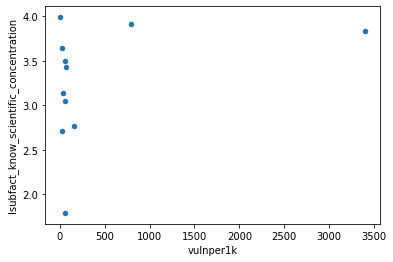

In [202]:
country_bscore[country_bscore.country.isin(list(bottom20_gini.country))].plot.scatter(x='vulnper1k',y='lsubfact_know_scientific_concentration')

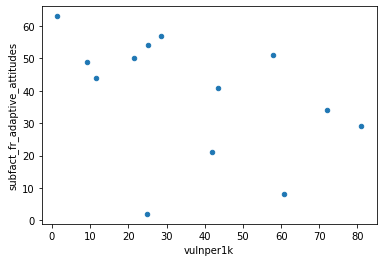

In [204]:
country_bscore[(country_bscore.vulnper1k<100) & (country_bscore.country.isin(top_vuln_countries.country))][corrlist].plot.scatter(x='vulnper1k',y='subfact_fr_adaptive_attitudes')

In [192]:
country_bscore[country_bscore.country.isin(top_vuln_countries.country)][corrlist].corr()

,population_2020,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,subfact_tech_technological_framework,subfact_fr_adaptive_attitudes,subfact_fr_business_agility,subfact_fr_it_integration,gini_value,totalcount,vulnper1k,avg
population_2020,1.000000,0.480874,0.380167,0.558142,0.396258,0.473970,0.277472,0.323049,0.484214,0.429686,0.565903,0.092379,0.121043,0.278097,0.299579,0.039973,-0.156779,-0.084255
overall_performance,0.480874,1.000000,0.974942,0.972916,0.980123,0.960278,0.858916,0.872527,0.952686,0.922996,0.868649,0.645431,0.749254,0.664860,0.510010,-0.060526,-0.280368,0.344848
factor_knowledge,0.380167,0.974942,1.000000,0.913017,0.965124,0.959977,0.921340,0.859134,0.923493,0.858062,0.825275,0.704513,0.826573,0.753690,0.408821,-0.110042,-0.345124,0.337780
factor_technology,0.558142,0.972916,0.913017,1.000000,0.946716,0.923855,0.807039,0.786747,0.966742,0.928263,0.899658,0.492898,0.641813,0.518858,0.554716,0.020079,-0.262889,0.341894
factor_future_readiness,0.396258,0.980123,0.965124,0.946716,1.000000,0.930924,0.856023,0.835994,0.955754,0.897255,0.808955,0.627907,0.763714,0.629421,0.494671,-0.011871,-0.194450,0.377213
subfact_know_talent,0.473970,0.960278,0.959977,0.923855,0.930924,1.000000,0.847683,0.782218,0.901038,0.854039,0.888035,0.620675,0.764856,0.675776,0.547527,-0.102665,-0.402320,0.306631
subfact_know_training_education,0.277472,0.858916,0.921340,0.807039,0.856023,0.847683,1.000000,0.697891,0.861789,0.704960,0.749674,0.546890,0.817327,0.670728,0.162967,-0.042007,-0.369155,0.081285
subfact_know_scientific_concentration,0.323049,0.872527,0.859134,0.786747,0.835994,0.782218,0.697891,1.000000,0.759668,0.871261,0.605469,0.778278,0.676860,0.739744,0.379542,-0.176271,-0.131798,0.383912
subfact_tech_regulatory_framework,0.484214,0.952686,0.923493,0.966742,0.955754,0.901038,0.861789,0.759668,1.000000,0.858719,0.819321,0.495227,0.687702,0.548774,0.457936,0.119422,-0.189348,0.298329
subfact_tech_capital,0.429686,0.922996,0.858062,0.928263,0.897255,0.854039,0.704960,0.871261,0.858719,1.000000,0.782870,0.532393,0.612292,0.492854,0.592641,-0.104968,-0.215059,0.470300


In [236]:
top_vuln_per1k=country_bscore[country_bscore.overall_performance>0].sort_values(by='vulnper1k',ascending=False).head(50)
bottom_vuln_per1k=country_bscore[country_bscore.overall_performance>0].sort_values(by='vulnper1k',ascending=True).head(50)


In [249]:
top_vuln_per1k[corrlist].corr()

Index(['population_2020', 'overall_performance', 'factor_knowledge',
       'factor_technology', 'factor_future_readiness', 'subfact_know_talent',
       'subfact_know_training_education',
       'subfact_know_scientific_concentration',
       'subfact_tech_regulatory_framework', 'subfact_tech_capital',
       'subfact_tech_technological_framework', 'subfact_fr_adaptive_attitudes',
       'subfact_fr_business_agility', 'subfact_fr_it_integration',
       'gini_value', 'totalcount', 'vulnper1k', 'avg'],
      dtype='object')

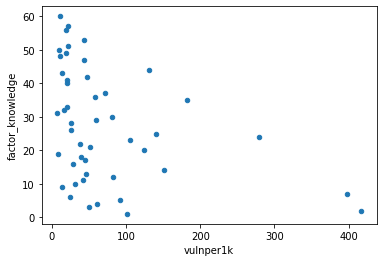

In [226]:
top_vuln_per1k[top_vuln_per1k.vulnper1k<450].plot.scatter(x='vulnper1k',y='factor_knowledge')

In [239]:
mannwhitneyu(top_vuln_per1k['factor_knowledge'],bottom_vuln_per1k['factor_knowledge'])

MannwhitneyuResult(statistic=1023.5, pvalue=0.05959573355316498)

In [248]:
mannwhitneyu(top_vuln_per1k['factor_future_readiness'],bottom_vuln_per1k['factor_future_readiness'])

MannwhitneyuResult(statistic=1079.5, pvalue=0.12057833359563125)

In [261]:

df_p=pd.DataFrame(columns=corrlist[1:], index=corrlist[1:])

In [270]:
for i in corrlist[1:]:
    print(i,mannwhitneyu(top_vuln_per1k[i],bottom_vuln_per1k[i])[1])

population_2020 0.06641699567531233
overall_performance 0.07191828722367843
factor_knowledge 0.05959573355316498
factor_technology 0.0540888126187296
factor_future_readiness 0.12057833359563125
subfact_know_talent 0.12908816696865705
subfact_know_training_education 0.07927642836737064
subfact_know_scientific_concentration 0.16378230369000407
subfact_tech_regulatory_framework 0.062934396186547
subfact_tech_capital 0.25623851177853496
subfact_tech_technological_framework 0.031577669190500285
subfact_fr_adaptive_attitudes 0.2179597669687856
subfact_fr_business_agility 0.2977465937142818
subfact_fr_it_integration 0.07097071780859074
gini_value 0.13041424721568656
totalcount 0.0318235799742811
vulnper1k 4.9010173043620706e-05
avg 0.46155212975882925


In [268]:
df_p

,population_2020,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,subfact_tech_technological_framework,subfact_fr_adaptive_attitudes,subfact_fr_business_agility,subfact_fr_it_integration,gini_value,totalcount,vulnper1k,avg
population_2020,0.066417,3.53304e-18,3.53304e-18,3.53304e-18,3.53224e-18,3.53304e-18,3.53304e-18,3.53304e-18,3.53304e-18,3.53304e-18,3.53304e-18,3.53144e-18,3.53144e-18,3.53065e-18,3.51475e-18,2.92244e-15,3.53304e-18,3.53304e-18
overall_performance,3.53304e-18,0.0719183,0.0695845,0.0537109,0.0910839,0.0839602,0.0548488,0.174207,0.0462564,0.103527,0.0504069,0.0767598,0.063788,0.0231542,0.0992575,3.53304e-18,0.138789,3.34151e-10
factor_knowledge,3.53304e-18,0.0583796,0.0595957,0.0449346,0.0777606,0.0738265,0.046592,0.150523,0.0373529,0.090519,0.0414596,0.062083,0.0525875,0.018506,0.0646638,3.53304e-18,0.151358,2.80544e-10
factor_technology,3.53304e-18,0.0714451,0.0700446,0.0540888,0.0888421,0.0855654,0.0560069,0.179574,0.0449355,0.103527,0.0522211,0.0792739,0.0673082,0.0235346,0.119898,3.53304e-18,0.148147,3.34151e-10
factor_future_readiness,3.53224e-18,0.0974537,0.0962716,0.0777618,0.120578,0.116478,0.0782621,0.230339,0.0668614,0.140291,0.0733455,0.11051,0.0910819,0.0373512,0.141068,3.53224e-18,0.122697,3.34112e-10
subfact_know_talent,3.53304e-18,0.1054,0.1054,0.0844923,0.133491,0.129088,0.0855654,0.234553,0.0752832,0.152952,0.0782646,0.114464,0.0986451,0.0414587,0.114476,3.53304e-18,0.104174,3.34151e-10
subfact_know_training_education,3.53224e-18,0.0877396,0.0910832,0.0733455,0.112475,0.111165,0.0792764,0.209925,0.0595952,0.134236,0.0709755,0.0962683,0.0828959,0.036791,0.0813411,3.53224e-18,0.117183,3.55955e-11
subfact_know_scientific_concentration,3.53304e-18,0.060416,0.060416,0.0446096,0.0752826,0.0738277,0.0459238,0.163782,0.0379191,0.0951001,0.0417659,0.0625064,0.0552299,0.0175877,0.065098,3.53304e-18,0.137269,3.56002e-11
subfact_tech_regulatory_framework,3.53304e-18,0.0927887,0.0894011,0.0738265,0.117156,0.107297,0.0733449,0.229294,0.0629344,0.140293,0.0705095,0.110512,0.0916473,0.0338421,0.172448,3.53304e-18,0.12695,3.34151e-10
subfact_tech_capital,3.53304e-18,0.197249,0.191558,0.158723,0.234551,0.219997,0.164633,0.361268,0.133492,0.256239,0.157889,0.210919,0.180476,0.0850244,0.227217,3.53304e-18,0.0584004,2.84966e-13


In [535]:
pc=sp.posthoc_conover(country_bscore[~country_bscore.income_group.isna()], val_col='gini_value', group_col='income_group')
pc

/opt/anaconda3/envs/enisa/lib/python3.7/site-packages/scikit_posthocs/_posthocs.py:216: RuntimeWarning:

invalid value encountered in sqrt



,High,Low,Lower middle,Upper middle
High,1.0,NaN,NaN,NaN
Low,NaN,1.0,NaN,NaN
Lower middle,NaN,NaN,1.0,NaN
Upper middle,NaN,NaN,NaN,1.0


In [1]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '1.5',  'square': True, 'cbar_ax_bbox': [0.90, 0.35, 0.04, 0.3]}
sp.sign_plot(pc)

NameError: name 'sp' is not defined